# [Projeto Maratona de Filmes](https://insper.github.io/supercomp/projetos/)

## Etapa 1: Adaptação do gerador e geração de múltiplos inputs

### 1.1. Adaptando o gerador
Somente uma adaptação foi realizada no funcionamento no gerador: a alteração da distribuição utilizada para gerar o número máximo de filmes para cada categoria. 

Inicialmente, a distribuição utilizada, tinha como limite superior o número de categorias existentes. Isso gerava um número máximo de filmes por categoria muito alto em alguns casos. Além disso, conforme o número de categorias aumentava, a média de filmes por categoria também crescia, fazendo com que esse limite não fosse tão relevante para inputs com alto número de categorias.

Como julgou-se que o limite de categorias deveria sempre ser relevante, alterou-se o código do gerador.

No caso, a distribuição foi alterada para que o limite superior fosse fixo e definido por um número arbitrário (10 foi escolhido, por ser o número médio de categorias). Como resultado, o limite de filmes por categoria pode manter uma relevância mais constante. Isso, por fim, permite manter um foco maior na variação do número de categorias, sem precisar levar em conta o aumento de seus limites.

### Código do gerador

```cpp
uniform_int_distribution<int> cat_limit(1, 10); // Novo gerador para o máximo de filmes por categoria
uniform_int_distribution<int> distribution_hr(0, 23);
uniform_int_distribution<int> distribution_cat(1, m); // Permanece sendo utilizado para gerar a categoria de cada filme

vector<int> maxFilmes(m); // Vetor para armazenar o máximo de filmes por categoria
for (int i = 0; i < m; i++)
{
    maxFilmes[i] = cat_limit(generator); // Gerando o máximo de filmes para cada categoria (alteração)
    inputFile << maxFilmes[i] << " ";    // Escrevendo o valor no arquivo de entrada
}
```

### 1.2. Geração de múltiplos inputs (`./code/gerador_multiple_cat_limit.cpp`)

Para realizar a geracão de múltiplos inputs, também foi necessário realizar algumas adaptações no código do gerador.

No caso, o que anteriormente era a função `main` foi transformada na função `void generate_tests(int n, int m, string file_name)`, que recebe como parâmetros o número de filmes a serem gerados, o número de categorias e o nome do arquivo de saída.

Dessa forma, criou-se um novo `main` que chama a função `generate_tests` para gerar os inputs de acordo com os parâmetros passados. Nesse `main` defini-se o número mínimo e máximo de filmes e categorias, que depois são combinados para gerar os inputs (podendo-se também configurar o step entre filmes ou categorias).

### Código do novo main do gerador

```cpp
int main(int argc, char *argv[])
{
    int min_categories = 1;
    int max_categories = 20;
    int min_movies = 0;
    int max_movies = 25000;
    int total = (max_categories - min_categories) * (max_movies - min_movies) / 50;

    for (int i = 1; i <= 50; i++)
    {
        for (int j = 1; j < 20; j++)
        {
            string file_name = "./input/input_" + to_string(i) + '_' + to_string(j) + ".txt";
            generate_tests(i, j, file_name);
        }
    }

    for (int i = min_movies; i <= max_movies; i += 50)
    {
        for (int j = min_categories; j < max_categories; j++)
        {
            string file_name = "./input/input_" + to_string(i) + '_' + to_string(j) + ".txt";
            generate_tests(i, j, file_name);
            total--;
            if (total % 1000 == 0)
                cout << total << endl;
        }
    }
    cout << total << endl;

    return 0;
}
```	

## Etapa 2: Implementação da [Heurística Gulosa](https://insper.github.io/supercomp/projetos/heuristico/)

### 2.1 Definir Regras

Antes de implementar o algoritmo, foi necessário definir as regras que seriam utilizadas para a resolução do problema. Elas foram:

1. Filmes que começam em um dia e terminam no outro são desconsiderados (Ex: inicio=23 e fim=2).
2. Filmes que começam e terminam no mesmo horário são desconsiderados (Ex: inicio=23 e fim=23).

<a id='regras'></a>

### 2.2 O Algoritmo Guloso

O objetivo dessa etapa é implementar um algoritmo que utiliza uma abordagem gulosa para resolver o problema. Os pré-requisitos para a implementação são:
1. Ordenar os filmes por hora de fim crescente.
2. Escolher aqueles que começam primeiro e não conflitam com os filmes já escolhidos.
3. Verificar se há vagas disponíveis na categoria do filme.

### 2.3 Implementação

A implementação do algoritmo guloso foi feita em C++. O código está disponível no arquivo `./code/greedy.cpp` (a partir da raiz do projeto) e foi compilado utilizando o compilador `g++` com o comando `g++ -g ./code/greedy.cpp -Wall -O3 -o ./greedy`.

### 2.3.2 Arquivos Header

Existe um arquivo header `./code/movie.h` que contém a definição da struct `Movie`. Essa struct é utilizada para representar os filmes e suas informações.

### 2.3.2 Funções auxiliares

1. `vector<int> setCategoryVector(int totalCategories)`
- Função que cria um vetor com o número de filmes por categoria.
- Recebe como parâmetro o número total de categorias.
- Retorna um vetor com o número de filmes por categoria.
- Categoria 1 = vetor[0], Categoria 2 = vetor[1], etc.
    
2. `vector<Movie> setMovieVector(int totalMovies)`
- Função que cria um vetor com os filmes.
- Recebe como parâmetro o número total de filmes.
- Retorna um vetor com os filmes (struct Movie).

3. `bool tryToAddMovie(vector<Movie> &watchlist, Movie &movie, bool timetable[24], int &freeSlots)`
- Função que tenta adicionar um filme na watchlist.
- Recebe como parâmetro a watchlist, o filme a ser adicionado, o array de horários disponíveis e o número de vagas disponíveis.
- Caso os horários que o filme em questão ocupa estejam disponíveis na `timetable`, modifica a `watchlist` (adiciona o filme), o array de horários disponíveis (torna os horários do filme como true (ocupados)) e o número de vagas disponíveis (decrementa o número de horas disponíveis na `timetable`).
- Retorna um booleano indicando se o filme foi adicionado ou não.

4. `bool sortSmallerDuration(Movie &i, Movie &j) { return i.duration < j.duration; }`
- Função que compara dois filmes pelo tempo de duração.
- Recebe como parâmetro dois filmes.
- Retorna um booleano indicando se o primeiro filme tem duração menor que o segundo.

5. `bool sortSmallerEndTime(Movie &i, Movie &j) { return i.endTime < j.endTime; }`
- Função que compara dois filmes pelo horário de término.
- Recebe como parâmetro dois filmes.
- Retorna um booleano indicando se o primeiro filme termina antes do segundo.

6. `bool sortSmallerId(Movie &i, Movie &j) { return i.id < j.id; }`
- Função que compara dois filmes pelo id.
- Recebe como parâmetro dois filmes.
- Retorna um booleano indicando se o primeiro filme tem id menor que o segundo.

7. `void printResult(vector<Movie> &watchlist, bool timetable[24])`
- Função que faz um output gráfico do resultado.
- Recebe como parâmetro a watchlist e o array de horários disponíveis.
- Não retorna nada.

### 2.3.3 Variáveis

1. `bool timetable[24]`
- Array de booleanos que indica se um horário do dia está ocupado ou não.
- Inicialmente nenhum horário está ocupado (false).
- Ex: 10 até 11 da manhã = timetable[10]

2. `int freeTimetableSlots`
- Inteiro que indica quantos horários ainda estão vagos
- Inicialmente todos (24)

3. `int totalMovies`
- Inteiro que indica o número total de filmes do input
    
4. `int totalCategories`
- Inteiro que indica o número total de categorias do input

5. `vector<int> categoryCount`
- Vetor que indica quantos filmes uma categoria ainda tem disponivel
- Inicialmente o número máximo de filmes por categoria
- Categoria 1 = vetor[0], Categoria 2 = vetor[1], etc.

6. `vector<Movie> movies`
- Vetor que possui todos os filmes disponíveis no arquivo de input

7. `vector<Movie> watchlist`
- Vetor que indica os filmes selecionados para serem assistidos
- Inicialmente vazio


### 2.3.3 Funcionamento do código:

#### a. Inicialização
1. Inicializa `timetable` e `freeTimetableSlots`
2. Declara `totalMovies` e `totalCategories`
3. Lê os dois primeiros valores do arquivo e determina `totalMovies` e `totalCategories`
4. Inicializa `categoryCount` utilizando a função `setCategoryVector(totalCategories)`
5. Inicializa `movies` utilizando a função `setMovieVector(totalMovies)`
6. Declara `watchlist`
7. Ordena `movies` por hora de fim crescente utilizando as funções `sort` e `sortSmallerEndTime`

#### b. Loop principal por todos os filmes do vetor movies
1. Verifica se `freeTimetableSlots` é igual a 0 (indica que não existem mais horários livres). Caso verdadeiro, encerrra o loop, pois não é possível adicionar mais filmes. 

2. Verifica se o horário de início do filme é maior que o de término ou se o filme começa e termina no mesmo horário ([Regras da etapa 2.1](#regras)). Caso verdadeiro, não considera o filme em questão, pulando para a próxima iteração do loop.

3. Verifica, por meio do vetor `categoryCount`, se o limite da categoria do filme em questão já foi atingido. Caso verdadeiro, não considera o filme em questão, pulando para a próxima iteração do loop, pois não seria permitido adicionar o filme à watchlist, uma vez que os espaços de sua categoria já se esgotaram. 

4. Chama a função `tryToAddMovie`. Ela tenta adicionar o filme à `watchlist` e se conseguir, atualiza a `watchlist`, a `timetable`, a `freeTimetableSlots` e retorna `true`. Caso retorne `true`, atualiza o `categoryCount` da categoria do filme em questão, para diminuir os filmes disponíveis para essa categoria.

#### c. Output
1. Verifica se foi passado algum argumento ao rodar o código. Caso falso, organiza a `watchlist` pela ordem do ID de seus filmes. Para isso utiliza as funções `sort` e `sortSmallerId`. Por fim, chama a função `printResult` para fazer um output gráfico do resultado

2. Verifica se o argumento passado ao rodar o código é o de benchmark. Caso verdadeiro, realiza um output reduzido, para análise posterior.


    

![greedy](./greedy_output.png)

### 2.3.4 Exemplo de output

#### Output gráfico (realizado no windows):
O output gráfico mostra, a quantidade de filmes selecionados (Movies to watch) e a quantiade de horários vazios na timetable (Free timetable slots).  

A seguir ele apresenta uma tabela, dividida por pipes, que possui as colunas ID (ID do filme), Start Time (hora de início do filme), End Time (hora de término do filme) e Category (categoria do filme).

No caso, cada linha após o header da tabela representa um dos filmes presentes na watchlist.

![greedy](./greedy_output.png)

#### Output reduzido para benchmark (realizado no windows):
O output para benchmark retorna apenas a quantidade de filmes na watchlist e o número de horários vagos na timetable

![greedy_benchmark](./greedy_benchmark_output.png)


## Etapa 3: Implementação da [Heurística Gulosa com Aleatoriedade](https://insper.github.io/supercomp/projetos/local/)

### 3.1 O Algoritmo Guloso com Aleatoriedade

O objetivo dessa etapa é adicionar um componente de aleatoriedade ao algoritmo guloso implementado previamente. O objetivo dessa etapa é permitir que a solução tenha um pouco mais de exploration e possa-se obter resultados melhores. Os pré-requisitos para a implementação são:
1. Ordenar os filmes por hora de fim crescente.
2. Escolher aqueles que começam primeiro e não conflitam com os filmes já escolhidos.
3. Verificar se há vagas disponíveis na categoria do filme.
4. Ao longo da seleção de um filme existir uma chance de 25% de pegar outro filme qualquer, que respeite o horário.

#### Detalhe -> Arquivos header e funções auxiliares permanecem os mesmos

### 3.2 Implementação

A implementação do algoritmo guloso com aleatoriedade foi feita em C++. O código está disponível no arquivo `./code/greedy_random.cpp` (a partir da raiz do projeto) e foi compilado utilizando o compilador `g++` com o comando `g++ -g ./code/greedy_random.cpp -Wall -O3 -o ./greedy_random`.

### 3.2.1 Variáveis adicionadas ao código

1. `default_random_engine generator`
- Gerador de números aleatórios
- Inicialmente com seed 10

2. `uniform_real_distribution<double> distribution(0.0, 1.0)`
- Distribuição uniforme de números aleatórios entre 0 e 1
- Utilizado para decidir se um filme aleatório será adicionado à watchlist

3. `int i = 1`
- Inteiro que indica a posição do filme que está sendo analisado
- Inicialmente 1, pois deve permanecer 1 a frente do filme que está sendo analisado


### 3.2.2 Funcionamento do código:

#### a. Inicialização
1. Inicializa `timetable` e `freeTimetableSlots`
2. Declara `totalMovies` e `totalCategories`
3. Lê os dois primeiros valores do arquivo e determina `totalMovies` e `totalCategories`
4. Inicializa `categoryCount` utilizando a função `setCategoryVector(totalCategories)`
5. Inicializa `movies` utilizando a função `setMovieVector(totalMovies)`
6. Declara `watchlist`
7. Ordena `movies` por hora de fim crescente utilizando as funções `sort` e `sortSmallerEndTime`
8. [+] Inicializa `generator` com seed 10 
9. [+] Inicializa `distribution` com valores entre 0 e 1
10. [+] Inicializa `i` com 1

#### b. Loop principal por todos os filmes do vetor movies
1. Verifica se `freeTimetableSlots` é igual a 0 (indica que não existem mais horários livres). Caso verdadeiro, encerrra o loop, pois não é possível adicionar mais filmes. 

2. [+] Verifica se o horário de início do filme é maior que o de término ou se o filme começa e termina no mesmo horário ([Regras da etapa 2.1](#regras)). Caso verdadeiro, não considera o filme em questão, pulando para a próxima iteração do loop e incrementado o contador `i`.

3. [+] Verifica, por meio do vetor `categoryCount`, se o limite da categoria do filme em questão já foi atingido. Caso verdadeiro, não considera o filme em questão, pulando para a próxima iteração do loop, pois não seria permitido adicionar o filme à watchlist, uma vez que os espaços de sua categoria já se esgotaram. Em seguida, incrementa o contador `i`.

4. Chama a função `tryToAddMovie`. Ela tenta adicionar o filme à `watchlist` e se conseguir, atualiza a `watchlist`, a `timetable`, a `freeTimetableSlots` e retorna `true`. Caso retorne `true`, atualiza o `categoryCount` da categoria do filme em questão, para diminuir os filmes disponíveis para essa categoria.

5. [+] Verifica se o número aleatório gerado por `distribution(generator)` é maior que 0.75 (25% de chance) e se o valor do contador `i` é menor que `totalMovies` (caso falso, continua a partir do final do `if`).
    5.1 Caso verdadeiro, gera um número aleatório entre `i` e `totalMovies` (entre o próximo filme do vetor e o último) e o salva na variável local `p`.   

    5.2 Verifica se a categoria do filme já foi preenchida (caso verdadeiro, incrementa `i` e pula para a próxima iteração do loop).   

    5.3 Caso a categoria não tenha sido preenchida, chama a função `tryToAddMovie`, que tenta adicionar um o filme aleatório à `watchlist` e se conseguir, atualiza a `watchlist`, a `timetable`, a `freeTimetableSlots` e retorna `true`.   

    5.4 Se `tryToAddMovie` retornar `true`, atualiza o `categoryCount` da categoria do filme aleatório em questão, para diminuir os filmes disponíveis para essa categoria, deleta o filme do vetor `movies` e diminui em 1 o valor de totalMovies, pois agora existe um filme a menos no vetor.

6. [+] Incrementa em 1 o contador `i`.

#### c. Output
1. Verifica se foi passado algum argumento ao rodar o código. Caso falso, organiza a `watchlist` pela ordem do ID de seus filmes. Para isso utiliza as funções `sort` e `sortSmallerId`. Por fim, chama a função `printResult` para fazer um output gráfico do resultado

2. Verifica se o argumento passado ao rodar o código é o de benchmark. Caso verdadeiro, realiza um output reduzido, para análise posterior.

### 3.2.3 Output 

#### Permanece no mesmo formato da solução gulosa

## Etapa 4: Profiling (valgrind)

### 4.1 Comandos utilizados

1. `g++ -g greedy.cpp -Wall -O3 -o ./greedy` (para compilar o código)
2. `valgrind --tool=callgrind ./greedy --benchmark < input_200_10.txt` (para rodar o código com o valgrind)
3. `callgrind_annotate --threshold=0.01 callgrind.out.43819 greedy.cpp > greedy_profiling.txt` (para gerar o arquivo de profiling e remover linhas de código que representem menos de 1% do total de ciclos ou instruções)
4. Repetir os passos para o código da solução gulosa com aleatoriedade e salvar em `greedy_random_profiling.txt` 

### 4.2 Resultados solução gulosa

Ao analisar o arquivo de profiling, pode-se fazer algumas observações:

1. Uma boa parte do tempo é gasta na função "_dl_lookup_symbol_x" do arquivo "dl-new-hash.h". Essa função faz parte da biblioteca padrão do C no GNU e é tem a função de fazer buscas de símbolos em bibliotecas dinâmicas. Por ser uma função padrão, está fora do escopo do projeto, mas talvez seja possível otimiá-la, caso seja possível identificar o motivo de sua utilização.

2. As funções "setMovieVector" e "setCategoryVector" do arquivo "greedy.cpp" gastaram 25,23% e 0,42% do tempo, respectivamente, e juntas representam mais de um quarto do tempo total. Isso sugere que há oportunidades para melhorar o desempenho examinando essas funções. Por se tratar de funções que inicializam os vetores de filmes e categorias, talvez fosse possível otimizar seu tempo de execução, por exemplo, utilizando alocação dinâmica de memória. Além disso, a leitura de entrada com "cin" também gastou uma quantidade significativa de tempo.


### 4.3 Resultados solução gulosa com aleatoriedade

Ao analisar o arquivo de profiling, pode-se notar que suas características são muito semelhantes às da solução gulosa. A única diferença que se pode notar é que a função "setMovieVector" gastou 25,12% do tempo (um pouco menos que a da solução gulosa, mas por ser exatamente a mesma função, provavelmente se deve a uma pequena diferença na leitura de entrada).

Além disso, em uma das ocasioes, a função "tryToAddMovie" gastou 0,04% do tempo, que apesar de ser um valor muito pequeno, é maior que o tempo gasto pela mesma função na solução gulosa (gasto menor que 0,01% dos ciclos totais).

### 4.4 Conclusões

Ambas as soluções possuem alto consumo de ciclos de processador nos mesmos pontos, o que indica que o gargalo do código está na leitura de entrada e na inicialização dos vetores de filmes e categorias.


## Etapa 5: Benchmark e comparação de resultados

### 5.1 Automatizando teste de diferentes inputs

Para poder testar múltiplos inputs para as duas heurísticas elaboradas, criou-se o script `./benchmark.py` (em relação a raiz do projeto). Esse script roda todos os arquivos de teste presente na pasta `./input` para um executável selecionado. Para cada arquivo de teste, esse script escreve uma linha de um arquivo `.txt` com o nome do arquivo de teste, o Stdout (output para benchmark: quantidade de filmes na watchlist e número de horários vagos na timetable), o Stderr caso haja e tempo total em segundos para rodar o programa para aquele arquivo de teste.

### 5.2 Resultados

Os resultados para o algoritmo guloso foram salvos no arquivo `./greedy_benchmark.txt` e para o algoritmo guloso com aleatoriedade no arquivo `./greedy_random_benchmark.txt`. Os resultados foram obtidos utilizando o executável `./greedy` e `./greedy_random` respectivamente.

#### 5.2.1 Leitura dos resultados e pre-processamento

In [1]:
# Lendo os resultados do benchmark e fazendo pre-processamento:

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

df_greedy = pd.read_csv("../greedy_benchmark.txt", sep="|")
df_greedy_random = pd.read_csv("../greedy_random_benchmark.txt", sep="|")

# Rename columns to name stripped:
df_greedy.columns = df_greedy.columns.str.strip()
df_greedy_random.columns = df_greedy_random.columns.str.strip()


# Column Stdout is composed of the following: {movies to watch} {free timetable slots}
# Convert it to two columns:
df_greedy[["movies_to_watch", "free_timetable_slots"]] = df_greedy["Stdout"].str.split(" ", expand=True)
df_greedy_random[["movies_to_watch", "free_timetable_slots"]] = df_greedy_random["Stdout"].str.split(" ", expand=True)

df_greedy["movies_to_watch"] = df_greedy["movies_to_watch"].astype(int)
df_greedy_random["movies_to_watch"] = df_greedy_random["movies_to_watch"].astype(int)
df_greedy["free_timetable_slots"] = df_greedy["free_timetable_slots"].astype(int)
df_greedy_random["free_timetable_slots"] = df_greedy_random["free_timetable_slots"].astype(int)

In [2]:
# assert stderr is empty:
assert df_greedy["Stderr"].isnull().all()
assert df_greedy_random["Stderr"].isnull().all()

In [3]:
# remove unnecessary columns:
df_greedy.drop(columns=["Stdout", "Stderr"], inplace=True)
df_greedy_random.drop(columns=["Stdout", "Stderr"], inplace=True)

In [4]:
# the column input file to two columns:
df_greedy["Input File"] = df_greedy["Input File"].str.replace("input_", "")
df_greedy["Input File"] = df_greedy["Input File"].str.replace(".txt", "")
df_greedy[["total_movies", "total_categories"]] = df_greedy["Input File"].str.split("_", expand=True)
df_greedy["total_movies"] = df_greedy["total_movies"].astype(int)
df_greedy["total_categories"] = df_greedy["total_categories"].astype(int)

df_greedy_random["Input File"] = df_greedy_random["Input File"].str.replace("input_", "")
df_greedy_random["Input File"] = df_greedy_random["Input File"].str.replace(".txt", "")
df_greedy_random[["total_movies", "total_categories"]] = df_greedy_random["Input File"].str.split("_", expand=True)
df_greedy_random["total_movies"] = df_greedy_random["total_movies"].astype(int)
df_greedy_random["total_categories"] = df_greedy_random["total_categories"].astype(int)

C:\Users\franb\AppData\Local\Temp\ipykernel_18644\3861184555.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_greedy["Input File"] = df_greedy["Input File"].str.replace(".txt", "")
C:\Users\franb\AppData\Local\Temp\ipykernel_18644\3861184555.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_greedy_random["Input File"] = df_greedy_random["Input File"].str.replace(".txt", "")


In [5]:
# Topo do dataframe com os resultados do greedy:
df_greedy.head(10)

,Input File,Tempo total(s),movies_to_watch,free_timetable_slots,total_movies,total_categories
0,10000_1,0.022025,8,16,10000,1
1,10000_10,0.022819,23,1,10000,10
2,10000_11,0.022546,23,1,10000,11
3,10000_12,0.022607,23,1,10000,12
4,10000_13,0.022680,23,1,10000,13
5,10000_14,0.022718,23,1,10000,14
6,10000_15,0.022827,23,1,10000,15
7,10000_16,0.023614,23,1,10000,16
8,10000_17,0.022657,23,1,10000,17
9,10000_18,0.022469,23,1,10000,18


In [6]:
# Topo do dataframe com os resultados do greedy_random:
df_greedy_random.head(10)

,Input File,Tempo total(s),movies_to_watch,free_timetable_slots,total_movies,total_categories
0,10000_1,0.022289,8,5,10000,1
1,10000_10,0.024761,15,1,10000,10
2,10000_11,0.022734,12,1,10000,11
3,10000_12,0.022030,14,1,10000,12
4,10000_13,0.021315,10,1,10000,13
5,10000_14,0.025569,11,1,10000,14
6,10000_15,0.021930,13,1,10000,15
7,10000_16,0.022065,13,1,10000,16
8,10000_17,0.021025,12,1,10000,17
9,10000_18,0.021670,10,1,10000,18


#### 5.2.2 Análise dos resultados

In [7]:
# Comparacao entre o describe dos dois dataframes:
df_greedy.describe()

,Tempo total(s),movies_to_watch,free_timetable_slots,total_movies,total_categories
count,10431.000000,10431.000000,10431.000000,10431.000000,10431.000000
mean,0.029074,19.351548,3.711916,11409.335155,10.000000
std,0.116148,6.422768,5.291460,7755.090334,5.477488
min,0.007259,0.000000,1.000000,1.000000,1.000000
25%,0.017011,18.000000,1.000000,4450.000000,5.000000
50%,0.027519,23.000000,1.000000,11300.000000,10.000000
75%,0.037880,23.000000,4.000000,18150.000000,15.000000
max,11.601778,23.000000,24.000000,25000.000000,19.000000


In [8]:
df_greedy_random.describe()

,Tempo total(s),movies_to_watch,free_timetable_slots,total_movies,total_categories
count,10431.000000,10431.000000,10431.000000,10431.000000,10431.000000
mean,0.025966,10.638002,2.546544,11409.335155,10.000000
std,0.012604,2.737914,3.970084,7755.090334,5.477488
min,0.006923,0.000000,1.000000,1.000000,1.000000
25%,0.015157,10.000000,1.000000,4450.000000,5.000000
50%,0.024889,11.000000,1.000000,11300.000000,10.000000
75%,0.035712,12.000000,1.000000,18150.000000,15.000000
max,0.086484,19.000000,24.000000,25000.000000,19.000000


Ao analisar o resumo dos resultados das duas heuristicas, percebe-se que a heuristica gulosa com aleatoriedade apresenta em média uma menor quantidade de filmes na watchlist e um menor número de horários vagos na timetable em relação à heuristica gulosa. Como o objetivo do problema é maximizar a quantidade de filmes na watchlist, a heuristica gulosa (sem aleatoriedade) parece ser a melhor solução para o problema. Caso o objetivo fosse minimizar o número de horários vagos na timetable, a heuristica gulosa com aleatoriedade seria a melhor solução.

In [9]:
# Remove outliers:
Q1 = df_greedy.quantile(0.1)
Q3 = df_greedy.quantile(0.9)
IQR = Q3 - Q1

df_greedy = df_greedy[~((df_greedy < (Q1 - 1.5 * IQR)) | (df_greedy > (Q3 + 1.5 * IQR))).any(axis=1)]
df_greedy_random = df_greedy_random[~((df_greedy_random < (Q1 - 1.5 * IQR)) | (df_greedy_random > (Q3 + 1.5 * IQR))).any(axis=1)]

C:\Users\franb\AppData\Local\Temp\ipykernel_18644\2953797026.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df_greedy.quantile(0.1)
C:\Users\franb\AppData\Local\Temp\ipykernel_18644\2953797026.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df_greedy.quantile(0.9)
C:\Users\franb\AppData\Local\Temp\ipykernel_18644\2953797026.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_greedy = df_greedy[~((df_greedy < (Q1 - 1.5 * IQR)) | (df_greedy > (Q3 + 

## Total de filmes Vs. Tempo de execução

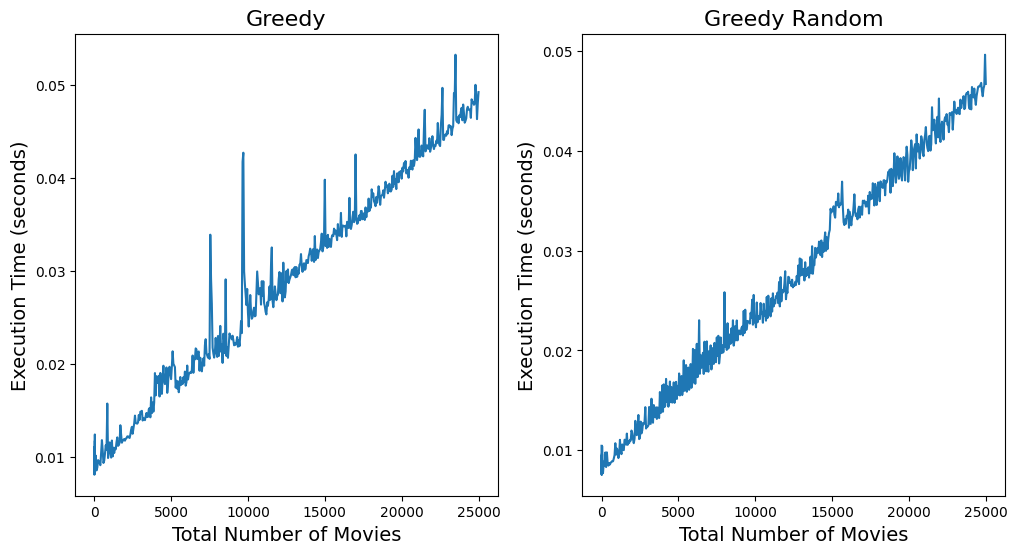

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_mov_greedy = df_greedy[['total_movies', 'Tempo total(s)']]
df_mov_greedy_rand = df_greedy_random[['total_movies', 'Tempo total(s)']]

# Group the data by the total number of categories and compute the mean execution time for each group
df_mov_greedy_gr = df_mov_greedy.groupby('total_movies').mean()
df_mov_greedy_rand_gr = df_mov_greedy_rand.groupby('total_movies').mean()

sns.lineplot(x='total_movies', y='Tempo total(s)', data=df_mov_greedy_gr, ax=axs[0])
sns.lineplot(x='total_movies', y='Tempo total(s)', data=df_mov_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Movies', fontsize=14)
axs[1].set_xlabel('Total Number of Movies', fontsize=14)
axs[0].set_ylabel('Execution Time (seconds)', fontsize=14)
axs[1].set_ylabel('Execution Time (seconds)', fontsize=14)

plt.show()

## Total de categorias Vs. Tempo de execução

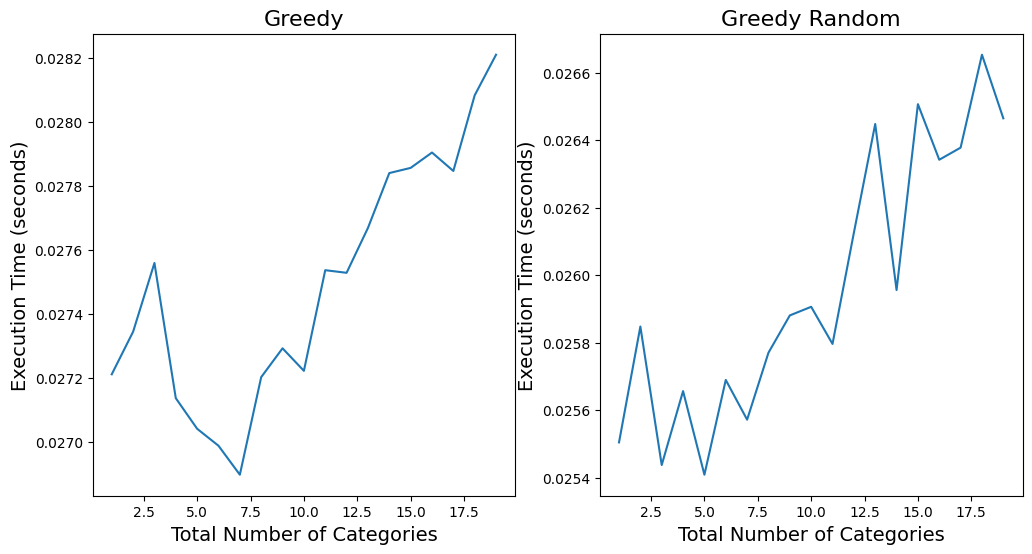

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_cat_greedy = df_greedy[['total_categories', 'Tempo total(s)']]
df_cat_greedy_rand = df_greedy_random[['total_categories', 'Tempo total(s)']]

# Group the data by the total number of categories and compute the mean execution time for each group
df_cat_greedy_gr = df_cat_greedy.groupby('total_categories').mean()
df_cat_greedy_rand_gr = df_cat_greedy_rand.groupby('total_categories').mean()

sns.lineplot(x='total_categories', y='Tempo total(s)', data=df_cat_greedy_gr, ax=axs[0])
sns.lineplot(x='total_categories', y='Tempo total(s)', data=df_cat_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Categories', fontsize=14)
axs[1].set_xlabel('Total Number of Categories', fontsize=14)
axs[0].set_ylabel('Execution Time (seconds)', fontsize=14)
axs[1].set_ylabel('Execution Time (seconds)', fontsize=14)

plt.show()


#### Total de filmes vs Tempo de execução

Agrupou-se os dados por quantidade de filmes e calculou-se a média do tempo de execução para cada quantidade de filmes. Com isso, foi possível plotar um gráfico que mostra a relação entre o tempo de execução e o número total de filmes por arquivo, para cada grupo de filmes.

Ao analisar o gráfico, pode-se perceber que o tempo de execução aumenta de forma linear com o número total de filmes, tanto para o algoritmo guloso quanto para o algoritmo guloso com aleatoriedade. Isso indica que o tempo de execução do algoritmo é proporcional ao número total de filmes, o que é esperado, já que o algoritmo precisa iterar por todos os filmes ou até que não haja mais horários livres (o que nem sempre acontece). 

Além disso, é possível perceber uma quantidade significativa de ruído em ambos os gráficos, o que pode ser explicado pelo fato de que o tempo de execução de cada arquivo de teste é diferente, e depende de multiplas variáveis.

#### Total de categorias vs Tempo de execução

O mesmo agrupamento foi realizado para o número total de categorias. Nesse caso, o agrupamento foi feito por quantidade de categorias e o tempo de execução foi calculado para cada quantidade de categorias.

Ao analisar ambos os gráficos, pode-se perceber que ambos aparentam apresentar uma correlação positiva entre o tempo de execução e o número total de categorias, mas que não se pode dizer com certeza que é linear. Além disso, essa correlação parece ser fraca e a taxa de crescimento total é pequena.

Também é possível perceber que ambos os gráficos apresentam um vale ao redor de 5 a 7 categorias. Isso pode ser explicado tanto pelo fato de ambas heuristicas utilizarem os mesmos arquivos de teste, ou pelo fato de que talvez exista uma quantidade de categorias não ideal para o problema, ou ainda por uma combinação dos dois.

De certa forma é dificil concluir alguma coisa sobre a relação entre o tempo de execução e o número total de categorias, já que apesar dos dois gráficos apresentarem um formato similar, não existe uma correlação muito clara. 

## Total de filmes Vs. Filmes na watchlist

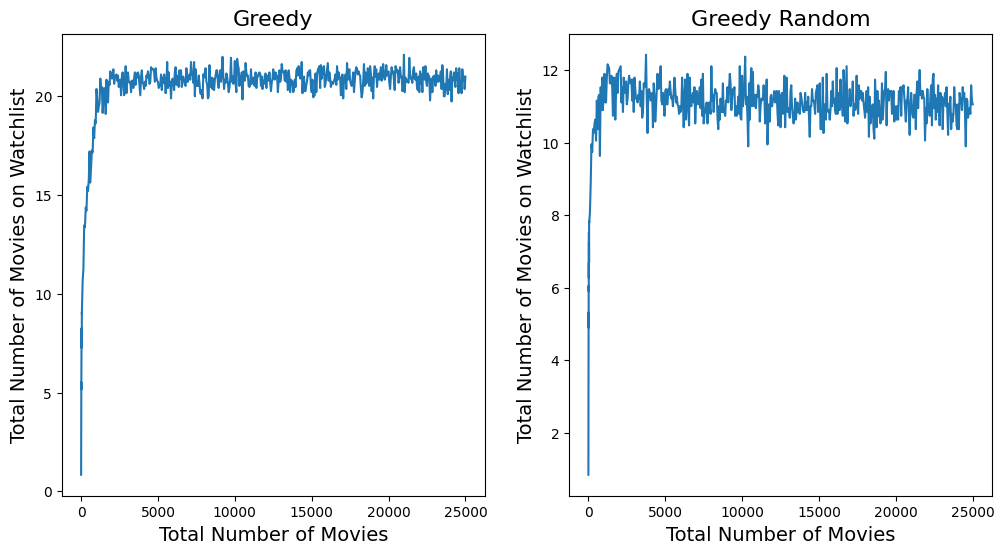

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_mov_greedy = df_greedy[['total_movies', 'movies_to_watch']]
df_mov_greedy_rand = df_greedy_random[['total_movies', 'movies_to_watch']]

# Group the data by the total number of movies and compute the mean amonunt of movies on watchlist for each group
df_mov_greedy_gr = df_mov_greedy.groupby('total_movies').mean()
df_mov_greedy_rand_gr = df_mov_greedy_rand.groupby('total_movies').mean()

sns.lineplot(x='total_movies', y='movies_to_watch', data=df_mov_greedy_gr, ax=axs[0])
sns.lineplot(x='total_movies', y='movies_to_watch', data=df_mov_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Movies', fontsize=14)
axs[1].set_xlabel('Total Number of Movies', fontsize=14)
axs[0].set_ylabel('Total Number of Movies on Watchlist', fontsize=14)
axs[1].set_ylabel('Total Number of Movies on Watchlist', fontsize=14)

plt.show()

## Total de categorias Vs. Filmes na watchlist

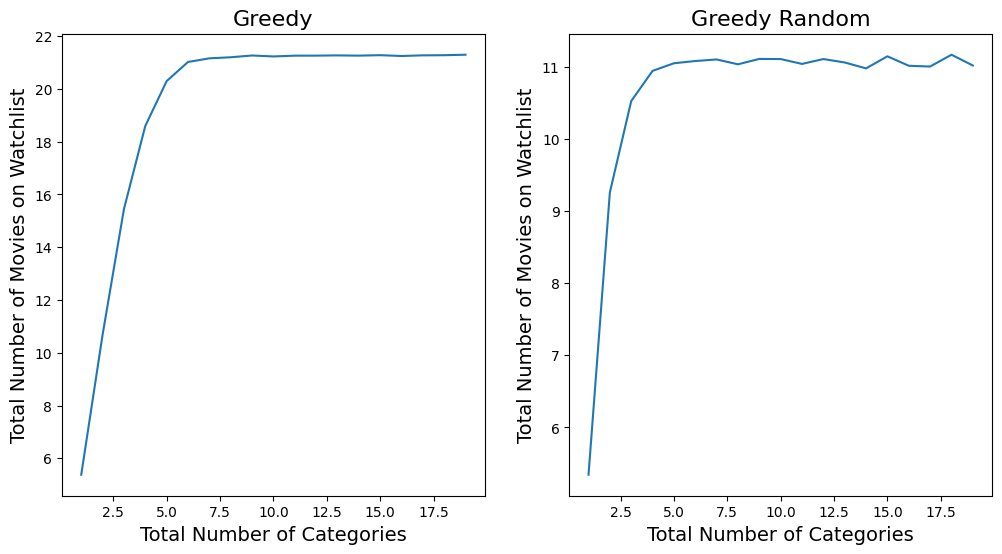

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_cat_greedy = df_greedy[['total_categories', 'movies_to_watch']]
df_cat_greedy_rand = df_greedy_random[['total_categories', 'movies_to_watch']]

# Group the data by the total number of categories and compute the mean amount of movies on the watchlist for each group
df_cat_greedy_gr = df_cat_greedy.groupby('total_categories').mean()
df_cat_greedy_rand_gr = df_cat_greedy_rand.groupby('total_categories').mean()

sns.lineplot(x='total_categories', y='movies_to_watch', data=df_cat_greedy_gr, ax=axs[0])
sns.lineplot(x='total_categories', y='movies_to_watch', data=df_cat_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Categories', fontsize=14)
axs[1].set_xlabel('Total Number of Categories', fontsize=14)
axs[0].set_ylabel('Total Number of Movies on Watchlist', fontsize=14)
axs[1].set_ylabel('Total Number of Movies on Watchlist', fontsize=14)

plt.show()

#### Comparação entre o número de filmes na watchlist e o número total de filmes e categorias

Ao observar os gráficos gerados, tanto para o número total de filmes quanto para o número total de categorias, é possível perceber que ambos possuem uma curva de crescimento, que aparenta ser logarítmica. O formato desses gráficos é muito semelhante tanto entre as heuristicas, quanto entre número total de filmes e número total de categorias. 

Isso indica que o aumento do número total de filmes e categorias impacta muito o número de filmes na watchlist, mas apenas até um certo ponto. Após esse ponto, o número de filmes na watchlist não aumenta mais de forma significativa, mesmo que o número total de filmes e categorias aumente.

Por fim, pode-se também perceber que apesar dos gráficos serem muito parecido e consistentes entre as heuristicas, quando se trata do formato, pode-se notar que a heuristica gulosa com aleatoriedade performa constantemente pior que a heuristica gulosa. No gráfico que compara o número total de filmes ao total na watchlist, a heuristica gulosa tende à um valor de, aproximadamente, 21, enquanto a gulosa com aleatoriedade tende à um valor de, mais ou menos, 11. Essa têndencia se repete nos gráficos que comparam o número total de categorias ao total na watchlist.

Também pode-se notar que a heuristica gulosa apresenta mais ruído, mas isso é resultado da própria natureza do algoritmo, que é aleatório.	 

## Total de filmes Vs. Horários vagos na timetable

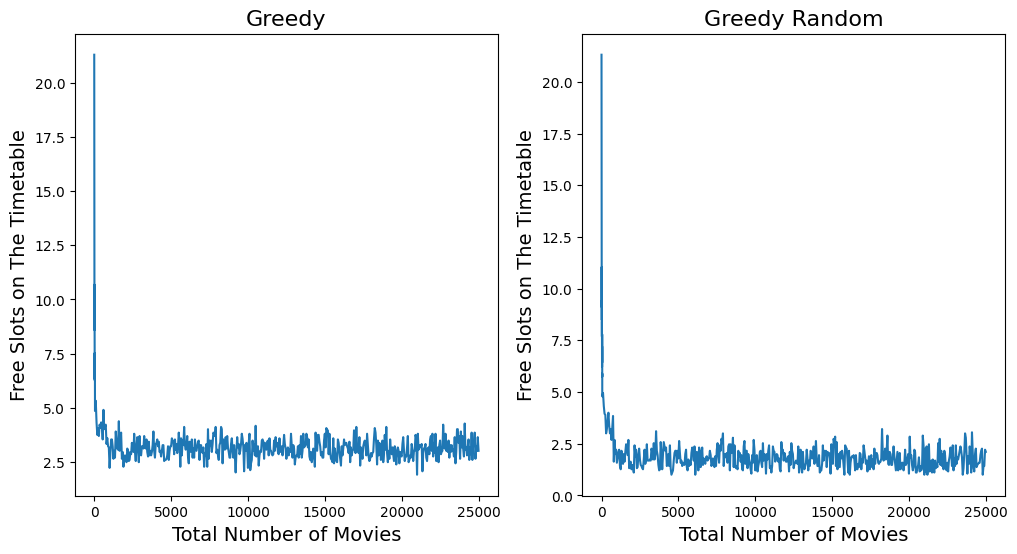

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_mov_greedy = df_greedy[['total_movies', 'free_timetable_slots']]
df_mov_greedy_rand = df_greedy_random[['total_movies', 'free_timetable_slots']]

# Group the data by the total number of movies and compute the mean number of free slots on the timetable for each group
df_mov_greedy_gr = df_mov_greedy.groupby('total_movies').mean()
df_mov_greedy_rand_gr = df_mov_greedy_rand.groupby('total_movies').mean()

sns.lineplot(x='total_movies', y='free_timetable_slots', data=df_mov_greedy_gr, ax=axs[0])
sns.lineplot(x='total_movies', y='free_timetable_slots', data=df_mov_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Movies', fontsize=14)
axs[1].set_xlabel('Total Number of Movies', fontsize=14)
axs[0].set_ylabel('Free Slots on The Timetable', fontsize=14)
axs[1].set_ylabel('Free Slots on The Timetable', fontsize=14)

plt.show()

## Total de categorias Vs. Horários vagos na timetable

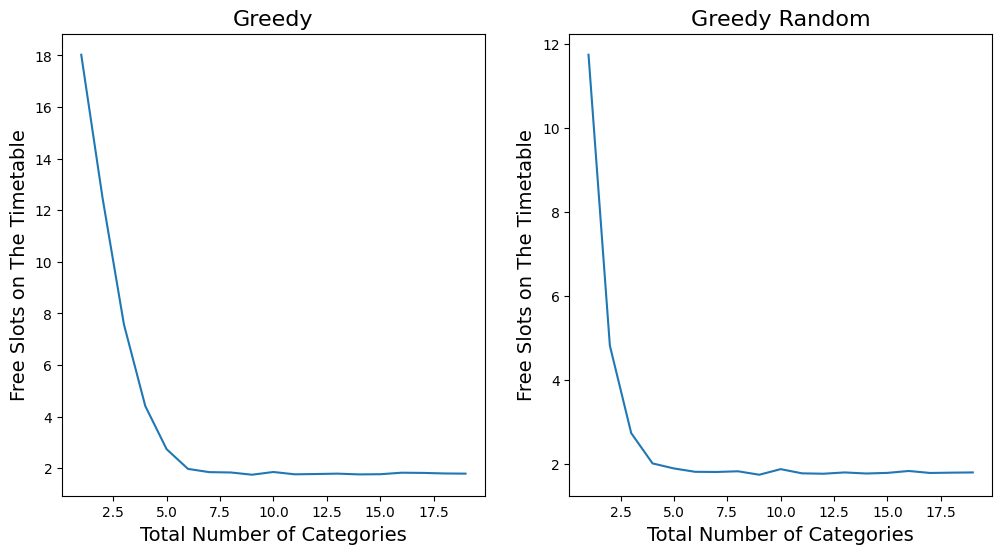

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_cat_greedy = df_greedy[['total_categories', 'free_timetable_slots']]
df_cat_greedy_rand = df_greedy_random[['total_categories', 'free_timetable_slots']]

# Group the data by the total number of categories and compute the mean number of free slots in the timetable for each group
df_cat_greedy_gr = df_cat_greedy.groupby('total_categories').mean()
df_cat_greedy_rand_gr = df_cat_greedy_rand.groupby('total_categories').mean()

sns.lineplot(x='total_categories', y='free_timetable_slots', data=df_cat_greedy_gr, ax=axs[0])
sns.lineplot(x='total_categories', y='free_timetable_slots', data=df_cat_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Categories', fontsize=14)
axs[1].set_xlabel('Total Number of Categories', fontsize=14)
axs[0].set_ylabel('Free Slots on The Timetable', fontsize=14)
axs[1].set_ylabel('Free Slots on The Timetable', fontsize=14)

plt.show()

#### Comparação entre o número de horas não preenchidas por filmes e o número total de filmes e categorias

Ao observar os gráficos gerados, tanto para o número total de filmes quanto para o número total de categorias, é possível perceber que ambos possuem uma curva de decaimento, que aparenta ser logarítmica. O formato desses gráficos é muito semelhante tanto entre as heuristicas, quanto entre número total de filmes e número total de categorias. 

Isso indica que o aumento do número total de filmes e categorias impacta muito o número de horas não preenchidas por filmes, mas apenas até um certo ponto. Após esse ponto, o número de horas não preenchidas não diminui mais de forma significativa, mesmo que o número total de filmes e categorias aumente.

Por fim, pode-se também perceber que, quando trata-se do formato, apesar dos gráficos serem muito parecido e consistentes entre as heuristicas, pode-se notar que a heuristica gulosa com aleatoriedade performa constantemente melhor que a heuristica gulosa. No gráfico que compara o número total de filmes ao total de horas vagas, a heuristica gulosa tende à um valor entre 2.5 e 5, enquanto a gulosa com aleatoriedade tende à um valor abaixo de 2.5. 

Para o gráfico de número total de categorias vs. número de horas vagas, ambas possuem uma tendência de aproximadamente 2, mas a heuristica gulosa com aleatoriedade chega à esse valor mais rapidamente.

Também pode-se notar que a heuristica gulosa apresenta mais ruído, mas isso é resultado da própria natureza do algoritmo, que é aleatório.	 

## Etapa 6: Conclusão comparativa entre a heurística gulosa e a heurística gulosa com aleatoriedade

No geral, o que pode-se perceber de relevante é que, para a tarefa dada de assistir o máximo de filmes possível, a heuristica gulosa performa melhor que a heuristica gulosa com aleatoriedade. No entanto, quando se trata de tempo de execução e minimização de horas vagas, a heuristica gulosa com aleatoriedade performa melhor.

Uma hipótese para esse resultado é que, a heuristica gulosa garante a seleção do número máximo de filmes que cabem no período de tempo e atendem aos limites da categoria. No entanto, essa abordagem pode resultar em filmes mais longos sendo selecionados primeiro, o que pode deixar menos opções para filmes mais curtos posteriormente.

Por outro lado, o segundo algoritmo introduz aleatoriedade no processo de seleção, o que às vezes pode levar a um uso mais eficiente do tempo de tela, pois pode selecionar filmes mais curtos no início do processo e deixar mais opções para filmes mais longos posteriormente. No entanto, existe o risco de o algoritmo selecionar muitos filmes aleatórios e poucos filmes de categorias específicas, levando a um uso ineficiente dos limites de categoria.

Em resumo, o algoritmo guloso sem aleatoriedade é mais determinístico e tende a priorizar o número de filmes assistidos, enquanto o segundo algoritmo (guloso com aleatoriedade) é mais aleatório e tende a priorizar a eficiência do tempo de tela, mas pode sacrificar alguns limites da categoria.

## Etapa 7: Implementação da solução exaustiva

### 7.1 Definir Regras

Para as regras da solução exaustiva, foram utilizadas as mesmas regras da solução gulosa, descritas na [Etapa 2.1](#regras).

### 7.2 A Busca Exaustiva

O objetivo dessa etapa é implementar um algoritmo que utiliza uma abordagem exaustiva para resolver o problema. Esse tipo de abordagem é muito custosa computacionalmente, mas garante a solução ótima para o problema. Os pré-requisitos para a implementação são:
1. Ordenar os filmes por hora de fim crescente.
2. Validar todas as combinações existentes de filmes.
3. Escolher a combinação válida que maximize o número de filmes assistidos.

<a id='7-a-busca-exaustiva'></a>

### 7.3 Implementação

A implementação da solução exaustiva foi feita em C++. O código está disponível no arquivo `./parallelism-code/exhaustive.cpp` (a partir da raiz do projeto) e foi compilado utilizando o compilador `g++` com o comando `g++ -g -Wall -o exhaustive .\parallelism-code\exhaustive.cpp .\parallelism-code\utils.cpp`.

### 7.3.1 Arquivos Header

A implementação da solução exaustiva utiliza dois arquivos header: `./parallelism-code/utils.h` e `./parallelism-code/movie.h`. O primeiro contém funções auxiliares para a leitura de entrada e preenchimento dos vetores de filmes e categorias. O segundo contém a definição da struct `Movie`, utilizada para representar os filmes e suas informações.

### 7.3.2 Funções auxiliares (utils.cpp)

1. `tuple<int, int> getInputParameters()`
- Função que lê os dois primeiros valores do arquivo de entrada (número total de filmes e número total de categorias) e retorna uma tupla com esses valores.

2. `vector<int> setCategoryVector(int totalCategories)`
- Função que cria um vetor com o número de filmes por categoria.
- Igual à função utilizada na solução gulosa

3. `vector<Movie> setMovieVector(int totalMovies)`
- Função que cria um vetor com os filmes.
- Recebe como parâmetro o número total de filmes.
- Retorna um vetor com os filmes (struct Movie).
- Não adiciona filmes que não respeitam as regras do problema.


### 7.3.3 Funções auxiliares (exhaustive.cpp)

1. `int validateInput(int combinationCode, vector<Movie> dataVec, vector<int> catLimit, int movieCount)`
- Função que valida uma combinação de filmes.
- Recebe como parâmetro o código da combinação, o vetor de filmes, o vetor de limites de categoria e o número total de filmes.
- Caso a combinação seja válida, retorna o número de filmes assistidos. Caso contrário, retorna 0.
- Funcionamento:
    1. Para cada bit do código da combinação, verifica se o filme correspondente está presente na combinação, utilizando uma máscara binária. Essa máscara é um número binário que possui apenas um bit 1, que é deslocado para a esquerda a cada iteração do loop. Caso o resultado da operação binária AND entre o código da combinação e a máscara seja diferente de 0, o filme correspondente está presente na combinação. 
    2. Caso o filme esteja presente na combinação, verifica se ele foi o primeiro filme adicionado, caso seja, salva seu indice na variavel `int lastIndex`, incrementa `int result` e pula para a próxima iteração do loop. Caso contrário, verifica se o filme atual conflita com o filme anteriormente adicionado.
    3. Caso o horário de início do filme atual seja maior ou igual ao horário de término do filme anterior, verifica se o limite de categoria do filme atual já foi atingido. Caso não tenha sido, incrementa o número de filmes assistidos (`result`), atualiza o limite de categoria do filme atual e salva seu indice na variavel `int lastIndex`. Caso contrário, retorna 0.

### 7.3.4 Variáveis

1. `auto totalMovies`
- Inteiro que indica o número total de filmes do input

2. `auto totalCategories`
- Inteiro que indica o número total de categorias do input

3. `vector<int> categoryLimit`
- Vetor que indica o numero máximo de filmes por categoria

4. `vector<Movie> movies`
- Vetor que possui todos os filmes disponíveis no arquivo de input, que respeitam as regras do problema

5. `int movieCount`
- Inteiro que indica o número de filmes no vetor `movies` (filmes que respeitam as regras do problema)

6. `int maxBin`
- Inteiro que indica a ultima combinação binária possível para o número de filmes no vetor `movies`

7. `int maxMovies`
- Inteiro que indica o número máximo de filmes que podem ser assistidos (inicia com o valor 0)

### 7.3.5 Funcionamento do código:

#### a. Inicialização
1. Atribui os valores de `totalMovies` e `totalCategories` utilizando a função `getInputParameters()`
2. Atribui os valores de `categoryLimit` utilizando a função `setCategoryVector(totalCategories)`
3. Atribui os valores de `movies` utilizando a função `setMovieVector(totalMovies)`
4. Atribui o valor de `movieCount` como o tamanho do vetor `movies`
5. Atribui o valor de `maxBin` como 2 elevado ao número de filmes no vetor `movies` menos 1
6. Ordena `movies` por hora de fim crescente utilizando as funções `sort`
7. Declara `maxMovies` como 0

#### b. Loop principal por todas as combinações possíveis
1. Loop inicia em 1 e vai até `maxBin`, pois a combinação 0 não vai ter nenhum filme selecionado, sendo seu valor sempre igual ao inicial de `maxMovies` (0).
2. Verifica se o número de bits `1` na combinação atual é maior que 24 (número de horas disponíveis). Caso verdadeiro, pula para a próxima iteração do loop, pois a combinação não é válida.
3. Atribui o valor de `maxMovies` como o maior entre `maxMovies` e o valor retornado pela função `validateInput(i, movies, categoryLimit, movieCount)`, onde `i` é a combinação atual.

#### c. Output
1. Imprime o valor de `maxBin` e `maxMovies` no Stdout

### 7.3.6 Exemplo de output

O output mostra a maior combinação binária possível, que representa a seleção de todos os filmes, e o número máximo de filmes que podem ser assistidos.

![exhaustive](./exhaust_output.png)

## Etapa 8: Implementação da [Solução Exaustiva Paralela com OpenMP](https://insper.github.io/supercomp/projetos/openmp/)

### 8.1 A Busca Exaustiva Paralela com OpenMP

O objetivo dessa etapa é reimplementar o algoritmo exaustivo utilizando OpenMP para paralelizar o processo de validação das combinações. Os pré-requisitos para a implementação são os mesmos da [Etapa 7](#7-a-busca-exaustiva).

### 8.2 Implementação
A implementação da solução exaustiva foi feita em C++. O código está disponível no arquivo `./parallelism-code/exhaustive_omp.cpp` (a partir da raiz do projeto) e foi compilado utilizando o compilador `g++` com o comando `g++ -g -Wall -fopenmp -o exhaustive_omp .\parallelism-code\exhaustive_omp.cpp .\parallelism-code\utils.cpp`.


#### Diff entre a solução exaustiva e a solução exaustiva paralela
Como a solução exaustiva foi planejada e desenvolvida com a parelelização em mente, foi necessário apenas adicionar as diretivas do OpenMP para paralelizar o loop principal do código. Para isso, foi adicionada a diretiva `#pragma omp parallel for` antes do loop principal, para que o loop fosse executado em paralelo.

Além disso, foi adicionada a diretiva `#pragma omp critical` antes da linha que atualiza o valor de `maxMovies`, para garantir que apenas uma thread atualize o valor de `maxMovies` por vez.

## Etapa 9: Benchmark e comparação de resultados

### 9.1 Automatizando teste de diferentes inputs

O teste para diferentes inputs foi automatizado utilizando o script `benchmark_exhaustive.py`. Ele funciona da mesma forma que o `benchmark.py`, que foi utilizado para testar os algoritmos gulosos. A única diferença é que esse script utiliza uma regular expression para rodar apenas os arquivos de teste que possuem no maximo 26 filmes, pois o algoritmo exaustivo é muito custoso computacionalmente e o tempo de execução para arquivos com mais de 26 filmes é muito alto.


### 9.2 Resultados 

Os resultados para o algoritmo exaustivo foram salvos no arquivo `./exhaustive_benchmark.txt` e para o algoritmo exaustivo paralelo no arquivo `./exhaustive_omp_benchmark.txt`. Os resultados foram obtidos utilizando o executável `./exhaustive` e `./exhaustive_omp` respectivamente.

### 9.3 Leitura dos resultados e pre-processamento

In [16]:
df_exhaust = pd.read_csv("../exhaustive_benchmark.txt", sep="|")
df_exhaust_omp = pd.read_csv("../exhaustive_omp_benchmark.txt", sep="|")

# Rename columns to name stripped:
df_exhaust.columns = df_exhaust.columns.str.strip()
df_exhaust_omp.columns = df_exhaust_omp.columns.str.strip()

# Column Stdout is composed of the following:  {max binary number} {movies to watch}
# Convert it to two columns:
df_exhaust[["max_bin", "movies_to_watch"]] = df_exhaust["Stdout"].str.split(" ", expand=True)
df_exhaust_omp[["max_bin", "movies_to_watch"]] = df_exhaust_omp["Stdout"].str.split(" ", expand=True)

df_exhaust["max_bin"] = df_exhaust["max_bin"].astype(int)
df_exhaust_omp["max_bin"] = df_exhaust_omp["max_bin"].astype(int)
df_exhaust["movies_to_watch"] = df_exhaust["movies_to_watch"].astype(int)
df_exhaust_omp["movies_to_watch"] = df_exhaust_omp["movies_to_watch"].astype(int)

In [17]:
# assert stderr is empty:
assert df_exhaust["Stderr"].isnull().all()
assert df_exhaust_omp["Stderr"].isnull().all()

In [18]:
# remove unnecessary columns:
df_exhaust.drop(columns=["Stdout", "Stderr"], inplace=True)
df_exhaust_omp.drop(columns=["Stdout", "Stderr"], inplace=True)

In [19]:
# the column input file to two columns:
df_exhaust["Input File"] = df_exhaust["Input File"].str.replace("input_", "")
df_exhaust["Input File"] = df_exhaust["Input File"].str.replace(".txt", "")
df_exhaust[["total_movies", "total_categories"]] = df_exhaust["Input File"].str.split("_", expand=True)
df_exhaust["total_movies"] = df_exhaust["total_movies"].astype(int)
df_exhaust["total_categories"] = df_exhaust["total_categories"].astype(int)

df_exhaust_omp["Input File"] = df_exhaust_omp["Input File"].str.replace("input_", "")
df_exhaust_omp["Input File"] = df_exhaust_omp["Input File"].str.replace(".txt", "")
df_exhaust_omp[["total_movies", "total_categories"]] = df_exhaust_omp["Input File"].str.split("_", expand=True)
df_exhaust_omp["total_movies"] = df_exhaust_omp["total_movies"].astype(int)
df_exhaust_omp["total_categories"] = df_exhaust_omp["total_categories"].astype(int)

C:\Users\franb\AppData\Local\Temp\ipykernel_18644\153692974.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_exhaust["Input File"] = df_exhaust["Input File"].str.replace(".txt", "")
C:\Users\franb\AppData\Local\Temp\ipykernel_18644\153692974.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_exhaust_omp["Input File"] = df_exhaust_omp["Input File"].str.replace(".txt", "")


In [20]:
import numpy as np

df_exhaust['movies_analyzed'] = df_exhaust['max_bin'].apply(lambda x: np.log2(x+1))
df_exhaust_omp['movies_analyzed'] = df_exhaust_omp['max_bin'].apply(lambda x: np.log2(x+1))

In [21]:
df_exhaust.head(10)

,Input File,Tempo total(s),max_bin,movies_to_watch,total_movies,total_categories,movies_analyzed
0,10_1,0.008029,511,3,10,1,9.0
1,10_10,0.007267,255,4,10,10,8.0
2,10_11,0.007689,255,5,10,11,8.0
3,10_12,0.007952,1023,6,10,12,10.0
4,10_13,0.008192,1023,5,10,13,10.0
5,10_14,0.007348,255,6,10,14,8.0
6,10_15,0.007598,255,4,10,15,8.0
7,10_16,0.007781,511,5,10,16,9.0
8,10_17,0.008303,1023,4,10,17,10.0
9,10_18,0.007307,255,4,10,18,8.0


In [22]:
df_exhaust_omp.head(10)

,Input File,Tempo total(s),max_bin,movies_to_watch,total_movies,total_categories,movies_analyzed
0,10_1,0.030848,511,3,10,1,9.0
1,10_10,0.008736,255,4,10,10,8.0
2,10_11,0.009457,255,5,10,11,8.0
3,10_12,0.009721,1023,6,10,12,10.0
4,10_13,0.009226,1023,5,10,13,10.0
5,10_14,0.009372,255,6,10,14,8.0
6,10_15,0.009437,255,4,10,15,8.0
7,10_16,0.009066,511,5,10,16,9.0
8,10_17,0.009818,1023,4,10,17,10.0
9,10_18,0.009358,255,4,10,18,8.0


### 9.4 Análise dos resultados

In [23]:
df_exhaust.describe()

,Tempo total(s),max_bin,movies_to_watch,total_movies,total_categories,movies_analyzed
count,494.000000,4.940000e+02,494.000000,494.000000,494.000000,494.000000
mean,0.408184,9.745907e+05,4.831984,13.500000,10.000000,11.759109
std,1.566801,3.795406e+06,1.956450,7.507603,5.482778,6.682655
min,0.006870,0.000000e+00,0.000000,1.000000,1.000000,0.000000
25%,0.007505,6.300000e+01,3.000000,7.000000,5.000000,6.000000
50%,0.009397,2.047000e+03,5.000000,13.500000,10.000000,11.000000
75%,0.065371,1.310710e+05,6.000000,20.000000,15.000000,17.000000
max,14.330765,3.355443e+07,9.000000,26.000000,19.000000,25.000000


In [24]:
df_exhaust_omp.describe()

,Tempo total(s),max_bin,movies_to_watch,total_movies,total_categories,movies_analyzed
count,494.000000,4.940000e+02,494.000000,494.000000,494.000000,494.000000
mean,0.227771,9.745907e+05,4.831984,13.500000,10.000000,11.759109
std,0.864164,3.795406e+06,1.956450,7.507603,5.482778,6.682655
min,0.007539,0.000000e+00,0.000000,1.000000,1.000000,0.000000
25%,0.009144,6.300000e+01,3.000000,7.000000,5.000000,6.000000
50%,0.010245,2.047000e+03,5.000000,13.500000,10.000000,11.000000
75%,0.041995,1.310710e+05,6.000000,20.000000,15.000000,17.000000
max,7.958481,3.355443e+07,9.000000,26.000000,19.000000,25.000000


In [25]:
# test if all lines of column movies_to_watch are equal in the df_exhaust and df_exhaust_omp dataframes:
assert df_exhaust['movies_to_watch'].equals(df_exhaust_omp['movies_to_watch'])

In [26]:
# sample df_greedy and df_greedy_random to have the same number of rows as df_exhaust and df_exhaust_omp
# by limiting total_movies to 26
df_greedy_sample = df_greedy[df_greedy['total_movies'] <= 26]
df_greedy_random_sample = df_greedy_random[df_greedy_random['total_movies'] <= 26]

In [27]:
df_greedy_sample.describe()

,Tempo total(s),movies_to_watch,free_timetable_slots,total_movies,total_categories
count,494.000000,494.000000,494.000000,494.000000,494.000000
mean,0.009008,4.744939,11.965587,13.500000,10.000000
std,0.001353,1.979542,4.518705,7.507603,5.482778
min,0.007259,0.000000,2.000000,1.000000,1.000000
25%,0.008258,3.000000,9.000000,7.000000,5.000000
50%,0.008596,5.000000,11.000000,13.500000,10.000000
75%,0.009251,6.000000,15.000000,20.000000,15.000000
max,0.016839,9.000000,24.000000,26.000000,19.000000


In [28]:
df_greedy_random_sample.describe()

,Tempo total(s),movies_to_watch,free_timetable_slots,total_movies,total_categories
count,494.000000,494.000000,494.000000,494.000000,494.000000
mean,0.008411,4.530364,12.050607,13.500000,10.000000
std,0.002127,1.844373,4.408119,7.507603,5.482778
min,0.006923,0.000000,3.000000,1.000000,1.000000
25%,0.007532,3.000000,9.000000,7.000000,5.000000
50%,0.007836,5.000000,11.000000,13.500000,10.000000
75%,0.008351,6.000000,15.000000,20.000000,15.000000
max,0.032992,9.000000,24.000000,26.000000,19.000000


Para poder compara os resultados do 4 algoritmos implementados até agora, criou-se uma amostra dos dataframes de resultado dos algoritmos gulosos e guloso com aleatoriedade. 
Essas amostras foram criadas, simplemente limitando o número de filmes a 26, para que fosse possível rodar o algoritmo exaustivo e exaustivo paralelo para os mesmos arquivos de teste.
Dessa forma, pode-se comparar os resultados dos 4 algoritmos para os mesmos arquivos de teste.

Ao observar a descrição dos resultados, pode-se perceber que:
- O algoritmo exaustivo apresenta um tempo de execução muito maior que sua versão paralela, sendo em media, quase 2 vezes mais lento. 
- Por sua vez, o algoritmo exaustivo paralelo, apresenta um tempo de execução muito maior que os algoritmos gulosos e guloso com aleatoriedade, sendo em média, mais de 25 vezes maior.
- Este tipo de análise já era esperada, pois o algoritmo exaustivo é muito custoso computacionalmente, e o algoritmo exaustivo paralelo, apesar de ser mais rápido que o exaustivo, ainda é muito custoso computacionalmente. 
- Não é possível observar nessa análise, mas o algoritmo exaustivo possui uma complexidade de tempo de O(2^n), o que é muito mais alto que os algoritmos gulosos. Isso será melhor explorado na próxima etapa, utilizando gráficos de tempo de execução vs. número de filmes e categorias.
- O desempenho em relação ao número de filmes para assistir não é muito diferente entre os 4 algoritmos. Pelo fato de que o algoritmo exaustivo garante a solução ótima, ele sempre vai apresentar o maior número de filmes na watchlist, mas a diferença entre os 4 algoritmos é muito pequena, sendo em média, menor que 7%, o que representa muito menos que 1 filme de diferença.

### 9.5 Total de filmes Vs. Tempo de execução

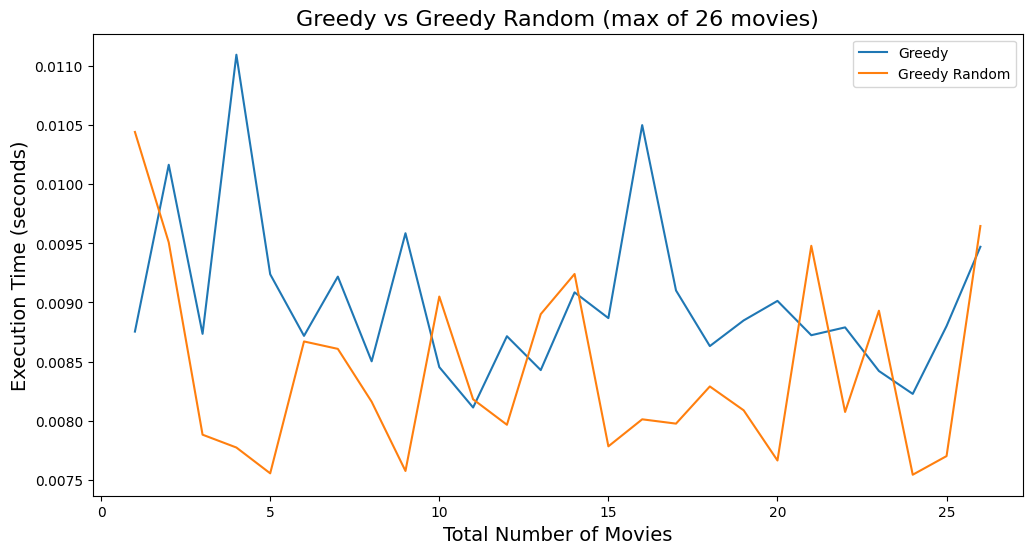

In [29]:
fig, axs = plt.subplots(ncols=1, figsize=(12, 6))

# Extract columns 
df_mov_greedy_sample = df_greedy_sample[['total_movies', 'Tempo total(s)']]
df_mov_greedy_rand_sample = df_greedy_random_sample[['total_movies', 'Tempo total(s)']]

# Group the data by the total number of categories and compute the mean execution time for each group
df_mov_greedy_gr_sample = df_mov_greedy_sample.groupby('total_movies').mean()
df_mov_greedy_rand_gr_sample = df_mov_greedy_rand_sample.groupby('total_movies').mean()

sns.lineplot(x='total_movies', y='Tempo total(s)', data=df_mov_greedy_gr_sample, label='Greedy')
sns.lineplot(x='total_movies', y='Tempo total(s)', data=df_mov_greedy_rand_gr_sample, label='Greedy Random')
plt.title('Greedy vs Greedy Random (max of 26 movies)', fontsize=16)
plt.xlabel('Total Number of Movies', fontsize=14)
plt.ylabel('Execution Time (seconds)', fontsize=14)

plt.legend()

plt.show()

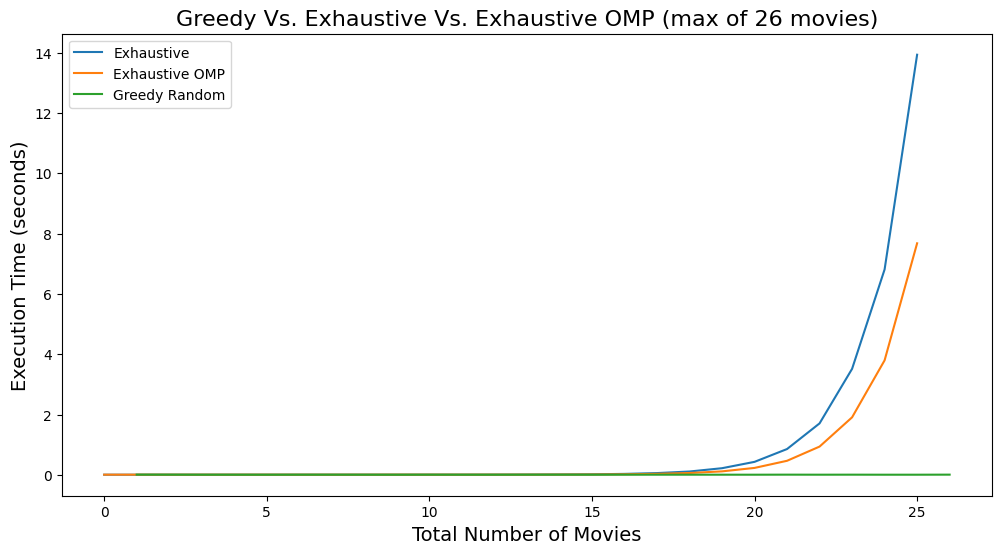

In [44]:
fig, axs = plt.subplots(figsize=(12, 6))

# Extract columns
df_mov_exhaust = df_exhaust[['movies_analyzed', 'Tempo total(s)']]
df_mov_exhaust_omp = df_exhaust_omp[['movies_analyzed', 'Tempo total(s)']]

# Group the data by the total number of categories and compute the mean execution time for each group
df_mov_exhaust_gr = df_mov_exhaust.groupby('movies_analyzed').mean()
df_mov_exhaust_omp_gr = df_mov_exhaust_omp.groupby('movies_analyzed').mean()

sns.lineplot(x='movies_analyzed', y='Tempo total(s)', data=df_mov_exhaust_gr, label='Exhaustive')
sns.lineplot(x='movies_analyzed', y='Tempo total(s)', data=df_mov_exhaust_omp_gr, label='Exhaustive OMP')
sns.lineplot(x='total_movies', y='Tempo total(s)', data=df_mov_greedy_rand_gr_sample, label='Greedy Random')

plt.title('Greedy Vs. Exhaustive Vs. Exhaustive OMP (max of 26 movies)', fontsize=16)

plt.xlabel('Total Number of Movies', fontsize=14)
plt.ylabel('Execution Time (seconds)', fontsize=14)

plt.legend()

plt.show()


#### Total de filmes vs Tempo de execução

Ao plotar tanto os gráficos de tempo de execução vs. número total de filmes, tanto para o algoritmo exaustivo quanto para o exaustivo paralelo, pode-se perceber que ambos possuem um crescimento exponencial muito claro. Isso indica que o tempo de execução aumenta de forma exponencial com o número total de filmes, o que é esperado, já que o algoritmo precisa iterar por todas as combinações possíveis de filmes e essas combinações aumentam exponencialmente com o número total de filmes.

Ao analisar o gráfico, pode-se perceber que o algoritmo exaustivo paralelo é mais rápido que o algoritmo exaustivo, mas ainda assim, a curva de crescimento de ambos é exponencial e extremamente maior que a curva de crescimento dos algoritmos gulosos, que não escalam de forma exponencial. Isso indica que o algoritmo exaustivo paralelo é muito mais rápido que o exaustivo, mas ainda assim, é muito custoso computacionalmente.

### 9.6 Total de filmes Vs. Filmes escolhidos

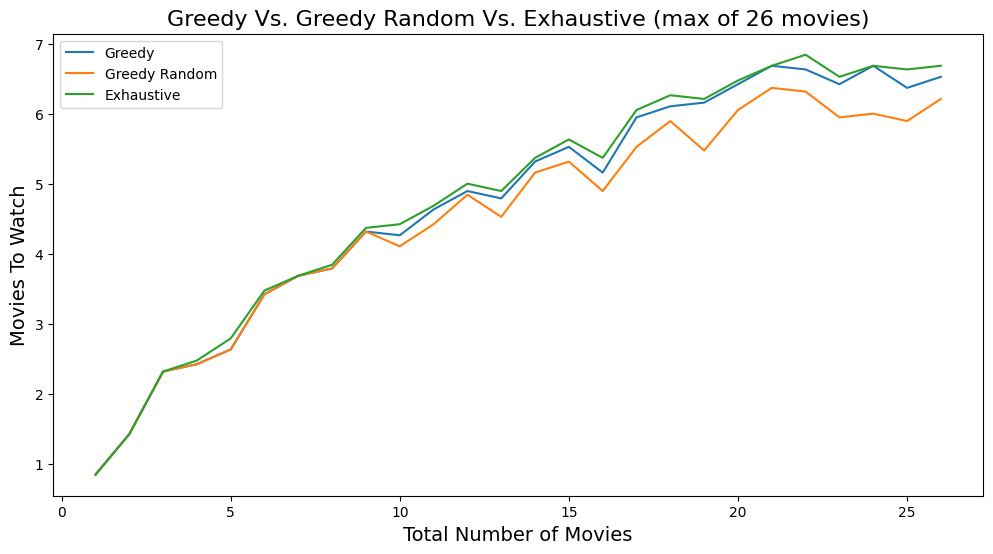

In [46]:
fig, axs = plt.subplots(ncols=1, figsize=(12, 6))

# Extract columns 
df_mov_greedy_sample = df_greedy_sample[['total_movies', 'movies_to_watch']]
df_mov_greedy_rand_sample = df_greedy_random_sample[['total_movies', 'movies_to_watch']]
df_mov_exhaust = df_exhaust[['total_movies', 'movies_to_watch']]	

# Group the data by the total number of categories and compute the mean execution time for each group
df_mov_greedy_gr_sample = df_mov_greedy_sample.groupby('total_movies').mean()
df_mov_greedy_rand_gr_sample = df_mov_greedy_rand_sample.groupby('total_movies').mean()
df_mov_exhaust_gr = df_mov_exhaust.groupby('total_movies').mean()

sns.lineplot(x='total_movies', y='movies_to_watch', data=df_mov_greedy_gr_sample, label='Greedy')
sns.lineplot(x='total_movies', y='movies_to_watch', data=df_mov_greedy_rand_gr_sample, label='Greedy Random')
sns.lineplot(x='total_movies', y='movies_to_watch', data=df_mov_exhaust_gr, label='Exhaustive')


plt.title('Greedy Vs. Greedy Random Vs. Exhaustive (max of 26 movies)', fontsize=16)
plt.xlabel('Total Number of Movies', fontsize=14)
plt.ylabel('Movies To Watch', fontsize=14)

plt.legend()

plt.show()

#### Total de filmes Vs. Filmes escolhidos

`Nota: Não se comparou o número de filmes escolhidos pelo algoritmo exaustivo paralelo, pois ele sempre escolhe o mesmo número de filmes que o algoritmo exaustivo, já que ambos garantem a solução ótima.`

Ao analisar o gráfico que compara as duas soluções gulosas com a exaustiva, pode-se perceber, que como era de se esperar, a solução exaustiva sempre escolhe o maior número de filmes possível, já que ela garante a solução ótima. No entanto, a diferença entre o número de filmes escolhidos pelas 3 soluções é muito pequena.

O motivo para esse resultado pode ser devido a forma com que os inputs foram gerados. Talvez para outra forma de geração de inputs, mais restritivos, a implementação exaustiva poderia ter uma vantagem maior em relação às soluções gulosas. No entanto, como esse não é o caso, pode-se julgar que a solução exaustiva não parece ser uma boa opção quando comparada às soluções gulosas, pois apesar de garantir a solução ótima, é muito custosa computacionalmente e não apresenta uma vantagem significativa em relação às soluções gulosas.

## Etapa 10: Implementação da [Solução Exaustiva Paralela com GPU](https://insper.github.io/supercomp/projetos/gpu/)

### 10.1 A Busca Exaustiva Paralela com GPU

O objetivo dessa etapa é reimplementar o algoritmo exaustivo utilizando a biblioteca Thrust para paralelizar o processo de validação das combinações em GPU. Os pré-requisitos para a implementação são os mesmos da [Etapa 7](#7-a-busca-exaustiva).

### 10.2 Implementação
A implementação da solução exaustiva com GPU foi feita em C++. O código está disponível no arquivo `./relatorio/relat-final-colab.ipynb` (a partir da raiz do projeto) e foi compilado no Google Colab utilizando o compilador `nvcc` com o comando `!nvcc -Wno-deprecated-gpu-targets -arch=sm_37 -std=c++14 -o main main.cu cuda_utils.cu`.


#### Diff entre a solução exaustiva e a solução exaustiva paralela GPU
Criou-se uma struct chamada `validate` que é um functor. Esse functor serve para validação de uma combinação de filmes e funciona da mesma maneira que a validaçao da solução exaustiva paralela com OpenMP. A diferença é que o functor é executado em GPU, utilizando a biblioteca Thrust.

O `validate` possui 4 atributos:
- `const int movieCount`: número de total de filmes validos
- `thrust::device_ptr<const int> catLimit`: ponteiro para o vetor de limites de categoria
- `thrust::device_ptr<const int> movieStart`: ponteiro para o vetor de horário de início dos filmes
- `thrust::device_ptr<const int> movieEnd`: ponteiro para o vetor de horário de fim dos filmes
- `thrust::device_ptr<const int> movieCat`: ponteiro para o vetor de categoria dos filmes

Além disso o `validate` também possui o método `__device__ int operator()(const int &bin)`, que executa a validação da combinação. Esse método recebe como parâmetro o código da combinação e retorna o número de filmes assistidos caso a combinação seja válida, ou 0 caso contrário.

Outro detalhe importante foi a necessidade de criar um array de 20 elementos dentro do operator para armazenar a quantia de filmes selecionados por categoria. Isso foi necessário pois não é possível alocar memória dinamicamente em GPU, então foi necessário criar um array de tamanho fixo.

Na função `main` criou-se um `counting_iterator` que vai de 0 até o número máximo de combinações possíveis. Esse iterator é passado para a função `thrust::transform` que preenche um vetor com o resultado da validação de cada combinação, que é realizada utilizando o functor `validate`. Esse vetor é passado para a função `thrust::reduce` que retorna o maior valor do vetor, que é o número máximo de filmes que podem ser assistidos.

## Etapa 11: Benchmark e comparação entre OpenMP e GPU

### 11.1 Plataforma de testes
Para realizar os testes da busca exaustiva em GPU, foi utilizado o Google Colab.
Como o benchmark do OpenMP anterior foi realizado em um computador pessoal, foi necessário realizar um novo benchmark para o OpenMP no Google Colab, para que fosse possível comparar os resultados do OpenMP e da GPU.
O arquivo ipynb com o benchmark do OpenMP e GPU no Google Colab está disponível em `../relatorio/colab_gpu.ipynb`.

### 11.2 Geração de inputs
Para não precisar copiar manualmente os arquivos de input locais para o Google Colab, foi escrito um código em pyton que gera inputs da mesma maneira que o gerador em C++. O código está disponível no ipynb `../relatorio/colab_gpu.ipynb`.

### 11.3 Resultados

Os resultados gerados no Google Colab foram salvos em diciionários e exportados para um arquivo `.json`. Os arquivos estão disponíveis em `../relatorio/colab_result_gpu.json` e `../relatorio/colab_result_omp.json`.

### 11.4 Leitura dos resultados e pre-processamento

In [31]:
df_omp = pd.read_json('./result_omp.json', orient='index')
df_gpu = pd.read_json('./result_gpu.json', orient='index')


# Rename columns:
column_names = [
    "Stdout", "Stderr", "Tempo total(s)", "Categorias", "Filmes"
    ]   

df_omp.columns = column_names
df_gpu.columns = column_names

# Split Stdout column into two columns:
df_omp[["Max Bin", "Filmes escolhidos"]] = df_omp["Stdout"].str.split(" ", expand=True)
df_gpu[['Max Bin', 'Filmes escolhidos']] = df_gpu['Stdout'].str.split(" ", expand=True)

df_omp["Max Bin"] = df_omp["Max Bin"].astype(int)
df_gpu["Max Bin"] = df_gpu["Max Bin"].astype(int)

df_omp["Filmes escolhidos"] = df_omp["Filmes escolhidos"].astype(int)
df_gpu["Filmes escolhidos"] = df_gpu["Filmes escolhidos"].astype(int)


# Remove Stdout column:
df_omp.drop(columns=["Stdout"], inplace=True)
df_gpu.drop(columns=["Stdout"], inplace=True)

df_omp.head(10)

,Stderr,Tempo total(s),Categorias,Filmes,Max Bin,Filmes escolhidos
1 1,,0.006790,1,1,1,1
2 1,,0.004007,1,2,3,2
3 1,,0.001739,1,3,3,2
4 1,,0.001642,1,4,15,3
5 1,,0.001712,1,5,31,2
6 1,,0.001654,1,6,63,3
7 1,,0.001659,1,7,63,5
8 1,,0.001710,1,8,255,3
9 1,,0.001817,1,9,127,3
10 1,,0.001983,1,10,1023,2


In [32]:
df_gpu.head(10)

,Stderr,Tempo total(s),Categorias,Filmes,Max Bin,Filmes escolhidos
1 1,,0.137936,1,1,1,1
2 1,,0.108813,1,2,3,2
3 1,,0.110951,1,3,3,2
4 1,,0.106557,1,4,15,3
5 1,,0.103614,1,5,31,2
6 1,,0.107089,1,6,63,3
7 1,,0.100227,1,7,63,5
8 1,,0.103597,1,8,255,3
9 1,,0.101977,1,9,127,3
10 1,,0.100501,1,10,1023,2


In [33]:
# Convert all Stderr to null if they are an empty string:
df_omp["Stderr"] = df_omp["Stderr"].replace("", np.nan, regex=False)
df_gpu["Stderr"] = df_gpu["Stderr"].replace("", np.nan, regex=False)

# assert stderr is empty:
assert df_omp["Stderr"].isnull().all()
assert df_gpu["Stderr"].isnull().all()

In [34]:
# Remove Stderr column:
df_omp.drop(columns=["Stderr"], inplace=True)
df_gpu.drop(columns=["Stderr"], inplace=True)

### 11.5 Análise dos resultados

In [35]:
df_omp.describe()

,Tempo total(s),Categorias,Filmes,Max Bin,Filmes escolhidos
count,494.000000,494.000000,494.000000,4.940000e+02,494.000000
mean,0.319712,10.000000,13.500000,9.026510e+05,4.894737
std,1.480369,5.482778,7.507603,4.230139e+06,1.980906
min,0.001642,1.000000,1.000000,0.000000e+00,0.000000
25%,0.001840,5.000000,7.000000,6.300000e+01,4.000000
50%,0.004204,10.000000,13.500000,4.095000e+03,5.000000
75%,0.081180,15.000000,20.000000,2.293750e+05,6.000000
max,23.927547,19.000000,26.000000,6.710886e+07,9.000000


In [37]:
df_gpu_sample = df_gpu[df_gpu['Filmes'] <= 26]

df_gpu_sample.describe()

,Tempo total(s),Categorias,Filmes,Max Bin,Filmes escolhidos
count,494.000000,494.000000,494.000000,4.940000e+02,494.000000
mean,0.110063,10.000000,13.500000,9.026510e+05,4.894737
std,0.012358,5.482778,7.507603,4.230139e+06,1.980906
min,0.097871,1.000000,1.000000,0.000000e+00,0.000000
25%,0.102312,5.000000,7.000000,6.300000e+01,4.000000
50%,0.104728,10.000000,13.500000,4.095000e+03,5.000000
75%,0.110489,15.000000,20.000000,2.293750e+05,6.000000
max,0.152174,19.000000,26.000000,6.710886e+07,9.000000


In [38]:
# Assert all lines of column 'Filmes escolhidos' are equal 
# in df_omp and df_gpu
assert df_omp['Filmes escolhidos'].equals(df_gpu_sample['Filmes escolhidos'])


#### Nota:
Foram testados inputs de até 26 filmes para a implementação em OpenMP e até 30 para a em GPU. No entanto, para garantir que a comparação do resultado da função `describe` fizesse sentido, fez-se uma amostra dos resultados para GPU que possuisem no máximo 26 filmes. Dessa forma, foi possível comparar os resultados do OpenMP e da GPU para os mesmos inputs de teste.

#### Análise inicial

Ao comparar os resultados da busca exaustiva utilizando OpenMP e GPU, pode-se perceber algumas características interessantes:
* A implementação em GPU aparenta ser, em média, aproximadamente 65% mais rápida que a implementação em OpenMP.
* Apesar da implementação com GPU possuir um tempo médio menor, ela apresenta um tempo mínimo de execução muito maior que a implementação com OpenMP. Além disso, o tempo mínimo da GPU é relativamente próximo ao seu tempo médio, o que pode indicar que existe um gargalo no código ou na infraestrutura utilizada, que limita o tempo mínimo de execução.
* O tempo máximo de execução da GPU é extremamente menor que o tempo máximo de execução do OpenMP (mais que 150x menor!), o que indica que a implementação em GPU é muito mais estável e rápida que a implementação em OpenMP.
* Como já visto antes, a implementação com OpenMP parece ter um crescimento de tempo exponencial, que pode ser antecipado ao observar o aumento de tempo para cada quartil do resultado. Por outro lado, a GPU parece ter um crescimento muito menos ingreme, que pode ser antecipado ao observar o aumento de tempo para cada quartil do resultado.

## 11.6 Ressalva em relação aos resultados

Antes de analisar os gráficos dos resultados, é importante lembrar que os resultados gerados pela implementação em GPU podem ser um pouco enganosos. Isso ocorre pois, a implementação em GPU tem um crescimento de memória exponencial, o que limita o número de filmes que podem ser testados. No caso, para inputs com mais de 30 filmes, já se pode deparar com casos onde a memória da GPU não é suficiente para armazenar todas as combinações possíveis de filmes e resulta em erros de memória.

Isso tudo faz com que a implementação em GPU tenha uma performance muito melhor que a implementação em OpenMP, mas não seja possível testar inputs muito grandes. Apesar do OpenMP demorar muito tempo para executar, ele consegue executar para qualquer input, coisa que a GPU não consegue.

No caso do benchmark, o limite de filmes escolhidos foi 26 não pelo limite de memória da GPU, mas sim pelo tempo de execução do OpenMP. Para inputs com mais de 26 filmes, o tempo de execução da implementação em OpenMP já é muito alto, o que torna o benchmark inviável.

No entanto, o limite de 26 foi seguido apenas para o teste do OpenMP, para os resultados do da GPU, foi utilizado o limite de 30 filmes, pois a implementação em GPU consegue executar para inputs com até 30 filmes em um tempo razoável.

### 11.7 Total de filmes Vs. Tempo de execução

In [39]:
# Convert Max Bin to log2(Max Bin + 1) in df_omp and df_gpu:
df_omp['Filmes Testados'] = df_omp['Max Bin'].apply(lambda x: np.log2(x+1))
df_gpu['Filmes Testados'] = df_gpu['Max Bin'].apply(lambda x: np.log2(x+1))

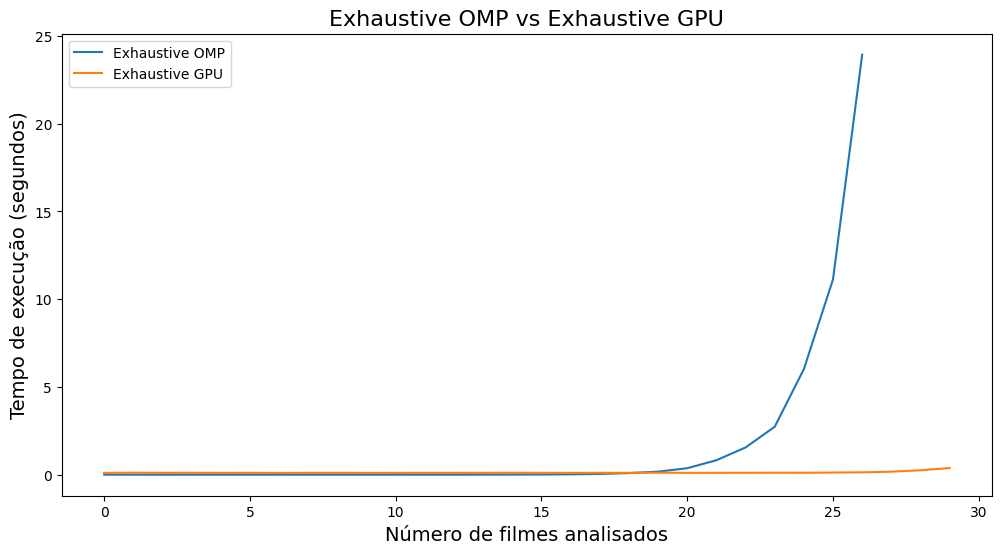

In [41]:
fig, axs = plt.subplots(figsize=(12, 6))

# Extract columns
df_omp = df_omp[['Filmes Testados', 'Tempo total(s)']]
df_gpu = df_gpu[['Filmes Testados', 'Tempo total(s)']]

# Group the data by the total number of categories and compute the mean execution time for each group
df_omp_gr = df_omp.groupby('Filmes Testados').mean()
df_gpu_gr = df_gpu.groupby('Filmes Testados').mean()

sns.lineplot(x='Filmes Testados', y='Tempo total(s)', data=df_omp_gr, label='Exhaustive OMP')
sns.lineplot(x='Filmes Testados', y='Tempo total(s)', data=df_gpu_gr, label='Exhaustive GPU')

plt.title('Exhaustive OMP vs Exhaustive GPU', fontsize=16)

plt.xlabel('Número de filmes analisados', fontsize=14)
plt.ylabel('Tempo de execução (segundos)', fontsize=14)

plt.legend()

plt.show()

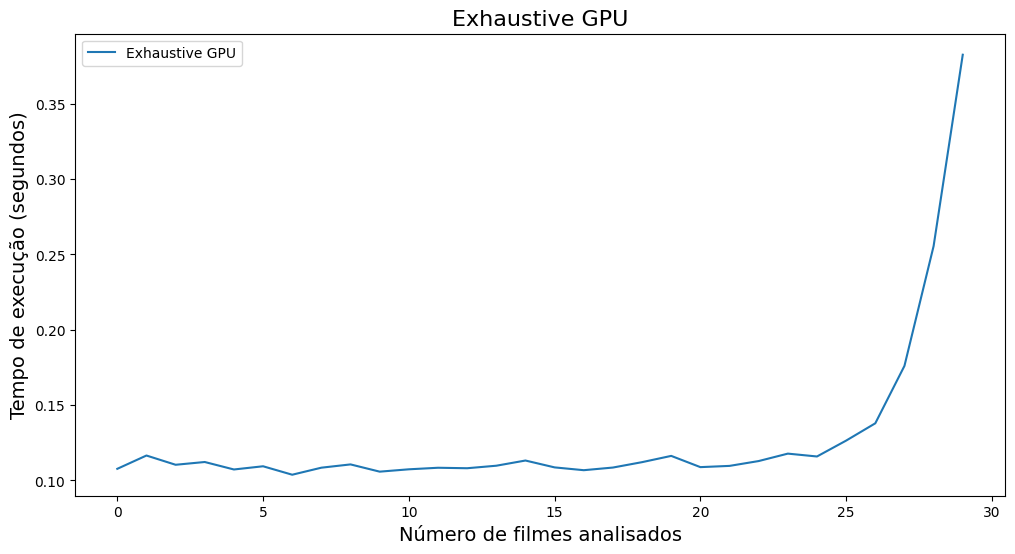

In [42]:
fig, axs = plt.subplots(figsize=(12, 6))


sns.lineplot(x='Filmes Testados', y='Tempo total(s)', data=df_gpu_gr, label='Exhaustive GPU')

plt.title('Exhaustive GPU', fontsize=16)

plt.xlabel('Número de filmes analisados', fontsize=14)
plt.ylabel('Tempo de execução (segundos)', fontsize=14)

plt.legend()

plt.show()

Ao plotar o resultado da implementação com OpenMP e com GPU no mesmo gráfico pode-se perceber que o código em GPU é extremamente mais rápido do que o código em OpenMP. Além disso, o crescimento do tempo de execução em relação ao número de filmes é muito menor para a implementação em GPU, o que indica que a implementação em GPU é muito mais eficiente que a implementação em OpenMP.

Ao analisar os dois resultados no mesmo gráfico, pode-se, erroneamente, concluir que o tempo de execução da implementação em GPU não escala de maneira exponencial com o número de filmes, mas sim de maneira linear. No entanto, isso não é verdade, e quando plota-se o resultado da implementação em GPU sozinho, pode-se perceber que o tempo de execução cresce de maneira exponencial com o número de filmes, da mesma forma que a implementação em OpenMP. O fato do crescimento do tempo de execução do OpenMP ser muito maior que o da GPU, faz com que o crescimento da GPU pareça linear, mas na verdade, também é exponencial.

## Etapa 12: Conclusão comparativa entre as soluções exaustivas e as soluções gulosas

Como se pode perceber as soluções exaustivas são muito custosas computacionalmente, e apesar de garantirem a solução ótima, não apresentam uma vantagem significativa em relação às soluções gulosas. Por isso, não parecem ser uma boa opção para o problema, dado a forma com que os inputs foram gerados.

Como dito antes, se os inputs fossem gerados de maneira menos permisiva, talvez as soluções exaustivas apresentassem uma vantagem maior em relação às soluções gulosas. No entanto, esse não é o caso.

Além disso, o tempo de execução das soluções exaustivas não escala bem com o número de filmes, o que faz com que elas não sejam viáveis para inputs com muitos filmes. Por outro lado, as soluções gulosas escalam muito bem com o número de filmes, o que faz com que elas sejam.

Existem formas de misturar as soluções exaustivas com as soluções gulosas, para tentar obter uma solução que seja mais rápida que a exaustiva e mais próxima da solução ótima que a gulosa. No entanto, isso não foi explorado nesse projeto.

Por fim, ao comparar a performance de tempo de execução entre a implementação em OpenMP e a implementação em GPU, pode-se perceber que a implementação em GPU é muito mais rápida que a implementação em OpenMP. No entanto, a implementação em GPU não consegue executar para inputs muito grandes, pois a memória da GPU é limitada. Por outro lado, a implementação em OpenMP consegue executar para qualquer input, mas demora muito tempo para executar.

Também pode-se perceber as vantagens de paralelizar o código para esse tipo de problema, que permite que o tempo de execução seja reduzido de forma significativa. No caso, a implementação em GPU foi aproximadamente 65% mais rápida que a implementação em OpenMP, o que é uma diferença muito grande.